In [1]:
from sys import platform
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

hi

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [5]:
def proc_df(cont_names, cat_names, *dataframes):
    df_all = pd.concat(dataframes, axis=0)
    df_all[cont_names] = df_all[cont_names].astype('float64')
    df_all[cat_names] = df_all[cat_names].astype('category')
    
    for df in dataframes:
        df[cont_names] = df[cont_names].astype('float64')
        df[cat_names] = df[cat_names].astype('category')
    
    ordered_cont_names = [col for col in df_all.columns if col in cont_names]
    ordered_cat_names = [col for col in df_all.columns if col in cat_names]    
    # nested list comprehension to get column names for onehot encoded categoy columns
    ordered_onehot_names = [f'{i}_{cat}' for cat in df_all[cat_names] for i in range(df_all[cat].nunique())]    
    names = ordered_cont_names + ordered_onehot_names
    
    # preprocessing pipeline
    pp = make_pipeline(
        FeatureUnion(transformer_list=[
            ('numeric_features', make_pipeline(
                TypeSelector('float64'),
                SimpleImputer(strategy='median'),
                QuantileTransformer()
            )),
            ('categorical_features', make_pipeline(
                TypeSelector('category'),
                SimpleImputer(strategy='most_frequent'),
                OneHotEncoder(categories='auto', handle_unknown='ignore')))
        ]))
    pp.fit(df_all)
    
    return(pd.DataFrame(pp.transform(df).toarray(), columns=names) for df in dataframes)    

# Data Import

In [6]:
PATH = Path('../data/houseprice/')
if platform == 'win32':
    !dir {PATH}
else:
    !ls {PATH}

 Datentr„ger in Laufwerk C: ist OS
 Volumeseriennummer: F49C-A1A7

 Verzeichnis von C:\Users\michaeljeremias\Documents\PythonProjects\data\houseprice

28.08.2019  12:55    <DIR>          .
28.08.2019  12:55    <DIR>          ..
03.05.2019  08:10            13ÿ370 data_description.txt
16.04.2019  09:57    <DIR>          models
15.04.2019  13:25            31ÿ939 sample_submission.csv
16.08.2019  12:49            27ÿ752 submission.csv
15.04.2019  13:25           451ÿ405 test.csv
15.04.2019  13:25           460ÿ676 train.csv
               5 Datei(en),        985ÿ142 Bytes
               3 Verzeichnis(se), 172ÿ884ÿ463ÿ616 Bytes frei


In [7]:
df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0)
df_test = pd.read_csv(PATH/'test.csv', sep=',', header=0)

In [8]:
df_y = df_train['SalePrice']
df_train.drop(['SalePrice'], axis=1, inplace=True)

In [9]:
cat_names = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
             'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
             'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
             'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'Heating',
             'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
             'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond',
             'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

In [10]:
cont_names = [name for name in df_train.columns if name not in cat_names]

In [11]:
proc_train, proc_test = proc_df(cont_names, cat_names, df_train, df_test)

In [12]:
proc_train.shape, proc_test.shape

((1460, 481), (1459, 481))

In [13]:
df_train.shape

(1460, 80)

# Autoencoder

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Sampler

In [15]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data to tensor

In [16]:
t_train = torch.tensor(proc_train.values, dtype=torch.float32, device=device)
t_test = torch.tensor(proc_test.values, dtype=torch.float32, device=device)
t_all = torch.cat([t_train, t_test], dim=0)
t_y = torch.tensor(df_y.values, dtype=torch.float32, device=device)
# Reshape to work with SwapnoiseDataset
t_y = t_y.reshape(-1,1)

## Loss

In [17]:
ae_loss = nn.MSELoss()

## Fitting function

In [18]:
train_losses = []

def fit(num_epochs, model, loss_fn, opt, dataloader):
    for epoch in range(num_epochs):
        for x, y in dataloader:
            preds = ae_model(x)
            loss = loss_fn(preds, x)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if (epoch+1)%10==0:
            train_losses.append(loss)
            print(f'Epoch: {epoch+1}\tTraining loss: {loss}')

## Autoencoder

### Undercomplete Autoencoder

In [41]:
class Autoencoder(nn.Module):
    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        self.num_features = num_features
        
        self.encoder = nn.Linear(num_features, 1000)
        self.bottle = nn.Linear(1000, 100)
        self.decoder = nn.Linear(100, 1000)
        self.out = nn.Linear(1000, num_features)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.act(self.encoder(x))
        x = self.bottle(x)
        x = x = self.act(self.decoder(x))
        x = self.out(x)
        return x

In [20]:
ae_model = Autoencoder(num_features=481).to(device)

In [21]:
ae_opt = torch.optim.Adam(ae_model.parameters())

In [22]:
ae_dataset = TensorDataset(t_all, t_all)
ae_dataloader = DataLoader(ae_dataset, batch_size=128)

In [23]:
fit(num_epochs=100, model=ae_model, loss_fn=ae_loss, opt=ae_opt, dataloader=ae_dataloader)

Epoch: 10	Training loss: 0.013682113029062748
Epoch: 20	Training loss: 0.009167433716356754
Epoch: 30	Training loss: 0.007098480127751827
Epoch: 40	Training loss: 0.005826777778565884
Epoch: 50	Training loss: 0.005080520175397396
Epoch: 60	Training loss: 0.00477374903857708
Epoch: 70	Training loss: 0.004008006304502487
Epoch: 80	Training loss: 0.00439222389832139
Epoch: 90	Training loss: 0.003783103544265032
Epoch: 100	Training loss: 0.003990411292761564


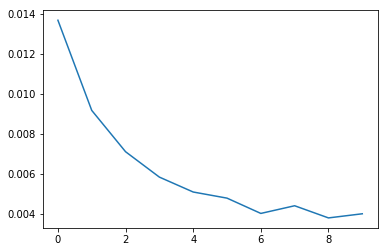

In [24]:
plt.plot(train_losses)

In [25]:
with torch.no_grad():
    ae_model.eval()
    t_features = ae_model.bottle(ae_model.act(ae_model.encoder(t_train)))

### Denoising Autoencoder (undercomplete)

We need a new TensorDataset class

In [29]:
class SwapnoiseDataset_old(TensorDataset):
    """
    A TensorDataset that implements the swapnoise noise scheme. 
    __getitem__ returns a row for tensor in the dataset (same as
    in TensorDataset), where every cell value is taken from the
    same column as the original cell, but from a random row with
    probability p, (p is set in p_noise).
    
    Arguments:
        p_noise (float or list of floats): probabilities for each tensor to
            replace the value of a cell with the value the same column but
            from a random row. For each tensor a swap probability must be supplied,
            even if it is 0. If all values in p_noise are 0 the behaviour is the
            same as a TensorDataset.
        tensors (tensor): tensors to load into the dataset.
    """
    
    def __init__(self, p_noise, *tensors):
        super(TensorDataset, self).__init__()
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        if len(tensors)>1:
            assert isinstance(p_noise, list)
            assert len(tensors) == len(p_noise)
        else:
            assert isinstance(p_noise, float)
        for noise in p_noise:
            assert noise >= 0 and noise <= 1
        
        self.tensors = tensors
        self.p_noise = p_noise
        self.length = tensors[0].size(0)
    
    def __getitem__(self, index):
        return tuple(tensor[self.swap_index(index, noise, self.length, tensor.size(1)), torch.tensor(range(tensor.size(1)))]                     
                     for tensor, noise in zip(self.tensors, self.p_noise))
    
    def __len__(self):
        return self.tensors[0].size(0)

    def swap_index(self, index, noise, high, size):
        init = torch.zeros(size) + noise
        select = torch.bernoulli(init).to(torch.uint8)
        #select_inv = select*(-1)+1
        rand_index = torch.randint(0, high, (size,))
        #return select*rand_index + select_inv*index
        return (select.to(torch.long)*rand_index + (~select).to(torch.long)*index)

    def getnoise(self):
        return self.p_noise

In [26]:
class SwapnoiseDataset(TensorDataset):
    """
    A TensorDataset that implements the swapnoise noise scheme. 
    __getitem__ returns a row for tensor in the dataset (same as
    in TensorDataset), where every cell value is taken from the
    same column as the original cell, but from a random row with
    probability p, (p is set in p_noise).
    
    Arguments:
        p_noise (float or list of floats): probabilities for each tensor to
            replace the value of a cell with the value the same column but
            from a random row. For each tensor a swap probability must be supplied,
            even if it is 0. If all values in p_noise are 0 the behaviour is the
            same as a TensorDataset.
        tensors (tensor): tensors to load into the dataset.
    """
    
    def __init__(self, noise, *tensors):
        
        device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
        super(TensorDataset, self).__init__()
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        if len(tensors)>1:
            assert isinstance(noise, list)
            assert len(tensors) == len(noise)
            for n in noise:
                assert n >= 0 and n <= 1
            self.rows = tensors[0].shape[0]
        else:
            assert isinstance(noise, float)        
            assert noise >= 0 and noise <= 1
            self.rows = tensors[0].shape[0]
        
        self.tensors = tensors
        self.noise = noise
        self.length = tensors[0].size(0)
        
        self.swap_idxs = []
        self.eff_noise = []
        self.idxs = torch.tensor(range(self.tensors[0].shape[0])).unsqueeze(1).to(device)
        self.shuffle(self.noise)
        
        
    
    def __getitem__(self, index):
        return tuple(torch.gather(tensor, 0, swap_idx[index].unsqueeze(0).to(device))
                     for tensor, swap_idx in zip(self.tensors, self.swap_idxs))
    
    def __len__(self):
        return self.tensors[0].size(0)
    
    def __repr__(self):
        return f"Swapnoise Dataset with {self.eff_noise} effective noise levels"

    def shuffle(self, noise=None):
        if noise is None:
            noise = self.noise        
        self.swap_idxs = []
        self.eff_noise = []
        for tensor, n in zip(self.tensors, noise):
            self.idxs_rand = torch.randint(0, tensor.shape[0], tensor.shape).to(device)
            select = torch.bernoulli(torch.zeros(tensor.shape) + n).to(torch.long).to(device)
            select_inv = (select * (-1) + 1)
            self.swap_idxs.append((select * self.idxs_rand) + (select_inv * self.idxs))
            self.eff_noise.append(select.to(torch.float).mean())

In [27]:
ae_model = Autoencoder(num_features=481).to(device)

In [28]:
ae_opt = torch.optim.Adam(ae_model.parameters())

In [29]:
sn_dataset = SwapnoiseDataset([0.3, 0], t_train, t_y)
sn_dataloader = DataLoader(sn_dataset, batch_size=128)

In [30]:
sn_dataset

Swapnoise Dataset with [tensor(0.2997), tensor(0.)] effective noise levels

In [31]:
print(sn_dataset)

Swapnoise Dataset with [tensor(0.2997), tensor(0.)] effective noise levels


In [32]:
train_losses = []
val_losses = []

In [33]:
%time fit(num_epochs=100, model=ae_model, loss_fn=ae_loss, opt=ae_opt, dataloader=sn_dataloader)

Epoch: 10	Training loss: 0.02504657208919525
Epoch: 20	Training loss: 0.009756848216056824
Epoch: 30	Training loss: 0.0056766364723443985
Epoch: 40	Training loss: 0.004665616434067488
Epoch: 50	Training loss: 0.003646292956545949
Epoch: 60	Training loss: 0.0037306826561689377
Epoch: 70	Training loss: 0.0028402693569660187
Epoch: 80	Training loss: 0.0028805069159716368
Epoch: 90	Training loss: 0.0027451845817267895
Epoch: 100	Training loss: 0.002882314147427678
Wall time: 28.5 s


In [34]:
%time fit(num_epochs=100, model=ae_model, loss_fn=ae_loss, opt=ae_opt, dataloader=ae_dataloader)

Epoch: 10	Training loss: 0.008603105321526527
Epoch: 20	Training loss: 0.006048618815839291
Epoch: 30	Training loss: 0.005594049580395222
Epoch: 40	Training loss: 0.005279121920466423
Epoch: 50	Training loss: 0.004368259105831385
Epoch: 60	Training loss: 0.004223709926009178
Epoch: 70	Training loss: 0.0033492902293801308
Epoch: 80	Training loss: 0.004140500910580158
Epoch: 90	Training loss: 0.0038491575978696346
Epoch: 100	Training loss: 0.004110286012291908
Wall time: 41.6 s


In [35]:
with torch.no_grad():
    ae_model.eval()
    sn_features = ae_model.bottle(ae_model.act(ae_model.encoder(t_train)))

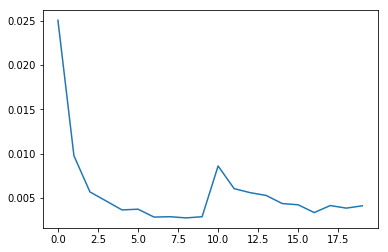

In [36]:
plt.plot(train_losses)

# Telemetry

In [37]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [40]:
for i,m in enumerate(ae_model):
    m.register_forward_hook(partial(append_stats, i))

TypeError: 'Autoencoder' object is not iterable